In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1772780980099797247,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5732106240
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18224500407919211113
 physical_device_desc: "device: 0, name: GeForce RTX 3070, pci bus id: 0000:0a:00.0, compute capability: 8.6"]

In [3]:
import tensorflow as tf

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [7]:
import chardet

In [8]:
filename = "train.csv"
with open(filename, 'rb') as f:
    result = chardet.detect(f.readline())  
    print(result['encoding'])

ascii


## 데이터 확인

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import chardet 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score

from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/gulim.ttc"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

path = 'C:/Users/Flora/떄회/2022.07/의류/'

df = pd.read_csv(path+'train.csv', encoding='EUC-KR')
df

,index,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,6,0,0,0,0,0,0,0,5,...,0,0,0,30,43,0,0,0,0,0
3,3,0,0,0,0,1,2,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,4,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,59995,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,59996,1,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,59997,8,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,59998,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold

In [23]:
#train/test에 index 빼고 다 넣어줌

In [11]:
train = pd.read_csv('train.csv').iloc[:, 1:]
test = pd.read_csv('test.csv').iloc[:, 1:]
submission = pd.read_csv('sample_submission.csv')

In [12]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
test.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,9,8,0,...,103,87,56,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,14,53,99,17,...,0,0,0,0,63,53,31,0,0,0
3,0,0,0,0,0,0,0,0,0,161,...,137,126,140,0,133,224,222,56,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
submission.head()

,index,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


## 데이터 가공

In [24]:
#데이터를 벡터화 / 예측값은 train에서 label값

In [ ]:
# 타겟값은 test의 벡터값

In [25]:
X = np.array(train.drop('label', axis = 1), dtype = 'float32')
y = train.label
target = np.array(test, dtype = 'float32')

### 스케일 조정

In [16]:
X/=255
target /=225

#### 이미지 보이기

In [ ]:
#이미지를 28*28로 바꿔서 이미지 보이는것

6번 클래스 의류


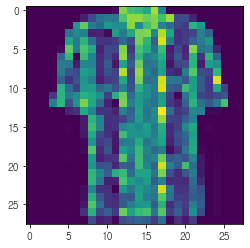

In [17]:
image = X[2020,:].reshape(28, 28)
print(f'{int(y[2020])}번 클래스 의류')
plt.imshow(image)
plt.show()

#### 사이즈 재조정

In [ ]:
#사이즈를 다 28*28로 바꿈

In [18]:
X = X.reshape(-1, 28, 28, 1)
target = target.reshape(-1, 28, 28, 1)

In [19]:
np.random.seed(1000)

### 훈련

In [20]:
skf = StratifiedKFold(n_splits=15, random_state=1000, shuffle = True)

In [21]:
reLR = ReduceLROnPlateau(patience = 5, verbose = 1, factor = 0.5)
es = EarlyStopping(patience = 5, verbose = 1, monitor = 'val_acc', mode = 'max')

In [22]:
sub_pred = np.zeros((test.shape[0], 10))

for i, (tr_idx, val_idx) in enumerate(skf.split(X, y)):
    print('='*25)
    print(f'{(i+1)}번째 학습 FOLD 학습시작')
    
    tr_x, tr_y = X[tr_idx], y[tr_idx]
    val_x, val_y = X[val_idx], y[val_idx]
    
    mc = ModelCheckpoint(f'cv_study{i+1}.h5', save_best_only=True, verbose = 1, monitor = 'val_acc', mode = 'max', save_weights_only = True)
    
    model = Sequential()
    
    model.add(Conv2D(64,(3,3),activation='relu',input_shape=(28,28,1),padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(5,5),activation='relu',padding='same')) 
    model.add(BatchNormalization())
    model.add(Conv2D(32,(5,5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(5,5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((3,3)))
    model.add(Dropout(0.3))
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(5,5),activation='relu',padding='same')) 
    model.add(BatchNormalization())
    model.add(MaxPooling2D((3,3)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(10,activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer = RMSprop(lr=0.003),metrics=['acc'])

    history = model.fit(tr_x, tr_y, epochs = 1000, 
                        validation_data = (val_x, val_y), callbacks = [es, mc, reLR])

    model.load_weights(f'cv_study{i + 1}.h5')

    pred = model.predict(target) / 15
    sub_pred += pred
    print(f'{i + 1}번째 학습 FOLD 학습 완료\n')

1번째 학습 FOLD 학습시작
Epoch 1/1000
1750/1750 [==============================] - 39s 19ms/step - loss: 0.5716 - acc: 0.7969 - val_loss: 0.3285 - val_acc: 0.8838

Epoch 00001: val_acc improved from -inf to 0.88375, saving model to cv_study1.h5
Epoch 2/1000
1750/1750 [==============================] - 32s 18ms/step - loss: 0.3687 - acc: 0.8730 - val_loss: 0.2736 - val_acc: 0.8980

Epoch 00002: val_acc improved from 0.88375 to 0.89800, saving model to cv_study1.h5
Epoch 3/1000
1750/1750 [==============================] - 32s 18ms/step - loss: 0.3201 - acc: 0.8900 - val_loss: 0.2562 - val_acc: 0.9122

Epoch 00003: val_acc improved from 0.89800 to 0.91225, saving model to cv_study1.h5
Epoch 4/1000
1750/1750 [==============================] - 32s 18ms/step - loss: 0.2955 - acc: 0.8988 - val_loss: 0.2485 - val_acc: 0.9112

Epoch 00004: val_acc did not improve from 0.91225
Epoch 5/1000
1750/1750 [==============================] - 32s 18ms/step - loss: 0.2764 - acc: 0.9061 - val_loss: 0.2200 - val_ac

1750/1750 [==============================] - 29s 16ms/step - loss: 0.1936 - acc: 0.9355 - val_loss: 0.1983 - val_acc: 0.9312

Epoch 00015: val_acc improved from 0.92775 to 0.93125, saving model to cv_study2.h5
Epoch 16/1000
1750/1750 [==============================] - 29s 16ms/step - loss: 0.1852 - acc: 0.9372 - val_loss: 0.2059 - val_acc: 0.9305

Epoch 00016: val_acc did not improve from 0.93125
Epoch 17/1000
1750/1750 [==============================] - 29s 16ms/step - loss: 0.1803 - acc: 0.9401 - val_loss: 0.2156 - val_acc: 0.9290

Epoch 00017: val_acc did not improve from 0.93125
Epoch 18/1000
1750/1750 [==============================] - 29s 16ms/step - loss: 0.1770 - acc: 0.9399 - val_loss: 0.2034 - val_acc: 0.9283

Epoch 00018: val_acc did not improve from 0.93125
Epoch 19/1000
1750/1750 [==============================] - 29s 17ms/step - loss: 0.1734 - acc: 0.9423 - val_loss: 0.2017 - val_acc: 0.9310

Epoch 00019: val_acc did not improve from 0.93125
Epoch 20/1000
1750/1750 [=====

1750/1750 [==============================] - 27s 16ms/step - loss: 0.0971 - acc: 0.9684 - val_loss: 0.2070 - val_acc: 0.9395

Epoch 00033: val_acc did not improve from 0.94175
Epoch 34/1000
1750/1750 [==============================] - 27s 16ms/step - loss: 0.0969 - acc: 0.9684 - val_loss: 0.2063 - val_acc: 0.9413

Epoch 00034: val_acc did not improve from 0.94175

Epoch 00034: ReduceLROnPlateau reducing learning rate to 0.000375000003259629.
Epoch 35/1000
1750/1750 [==============================] - 27s 16ms/step - loss: 0.0910 - acc: 0.9702 - val_loss: 0.2065 - val_acc: 0.9402

Epoch 00035: val_acc did not improve from 0.94175
Epoch 00035: early stopping
3번째 학습 FOLD 학습 완료

4번째 학습 FOLD 학습시작
Epoch 1/1000
1750/1750 [==============================] - 29s 16ms/step - loss: 0.5556 - acc: 0.8051 - val_loss: 0.3312 - val_acc: 0.8815

Epoch 00001: val_acc improved from -inf to 0.88150, saving model to cv_study4.h5
Epoch 2/1000
1750/1750 [==============================] - 27s 16ms/step - loss: 

1750/1750 [==============================] - 30s 17ms/step - loss: 0.3165 - acc: 0.8907 - val_loss: 0.2538 - val_acc: 0.9115

Epoch 00003: val_acc improved from 0.89075 to 0.91150, saving model to cv_study5.h5
Epoch 4/1000
1750/1750 [==============================] - 30s 17ms/step - loss: 0.2850 - acc: 0.9020 - val_loss: 0.2322 - val_acc: 0.9180

Epoch 00004: val_acc improved from 0.91150 to 0.91800, saving model to cv_study5.h5
Epoch 5/1000
1750/1750 [==============================] - 30s 17ms/step - loss: 0.2726 - acc: 0.9064 - val_loss: 0.2595 - val_acc: 0.9082

Epoch 00005: val_acc did not improve from 0.91800
Epoch 6/1000
1750/1750 [==============================] - 30s 17ms/step - loss: 0.2541 - acc: 0.9145 - val_loss: 0.2212 - val_acc: 0.9193

Epoch 00006: val_acc improved from 0.91800 to 0.91925, saving model to cv_study5.h5
Epoch 7/1000
1750/1750 [==============================] - 30s 17ms/step - loss: 0.2423 - acc: 0.9177 - val_loss: 0.2032 - val_acc: 0.9293

Epoch 00007: val

1750/1750 [==============================] - 29s 17ms/step - loss: 0.1531 - acc: 0.9488 - val_loss: 0.1773 - val_acc: 0.9402

Epoch 00018: val_acc improved from 0.93650 to 0.94025, saving model to cv_study6.h5
Epoch 19/1000
1750/1750 [==============================] - 29s 16ms/step - loss: 0.1448 - acc: 0.9511 - val_loss: 0.1928 - val_acc: 0.9388

Epoch 00019: val_acc did not improve from 0.94025
Epoch 20/1000
1750/1750 [==============================] - 29s 16ms/step - loss: 0.1452 - acc: 0.9515 - val_loss: 0.1930 - val_acc: 0.9385

Epoch 00020: val_acc did not improve from 0.94025
Epoch 21/1000
1750/1750 [==============================] - 29s 16ms/step - loss: 0.1385 - acc: 0.9541 - val_loss: 0.1941 - val_acc: 0.9373

Epoch 00021: val_acc did not improve from 0.94025
Epoch 22/1000
1750/1750 [==============================] - 29s 16ms/step - loss: 0.1337 - acc: 0.9552 - val_loss: 0.1897 - val_acc: 0.9383

Epoch 00022: val_acc did not improve from 0.94025
Epoch 23/1000
1750/1750 [=====

1750/1750 [==============================] - 29s 17ms/step - loss: 0.1865 - acc: 0.9374 - val_loss: 0.1977 - val_acc: 0.9340

Epoch 00016: val_acc improved from 0.93300 to 0.93400, saving model to cv_study8.h5
Epoch 17/1000
1750/1750 [==============================] - 29s 16ms/step - loss: 0.1786 - acc: 0.9398 - val_loss: 0.2036 - val_acc: 0.9365

Epoch 00017: val_acc improved from 0.93400 to 0.93650, saving model to cv_study8.h5

Epoch 00017: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.
Epoch 18/1000
1750/1750 [==============================] - 29s 17ms/step - loss: 0.1578 - acc: 0.9459 - val_loss: 0.1873 - val_acc: 0.9388

Epoch 00018: val_acc improved from 0.93650 to 0.93875, saving model to cv_study8.h5
Epoch 19/1000
1750/1750 [==============================] - 28s 16ms/step - loss: 0.1479 - acc: 0.9502 - val_loss: 0.1873 - val_acc: 0.9385

Epoch 00019: val_acc did not improve from 0.93875
Epoch 20/1000
1750/1750 [==============================] - 28s 16ms/step


Epoch 00017: val_acc did not improve from 0.93650
Epoch 18/1000
1750/1750 [==============================] - 28s 16ms/step - loss: 0.1783 - acc: 0.9396 - val_loss: 0.2146 - val_acc: 0.9360

Epoch 00018: val_acc did not improve from 0.93650
Epoch 19/1000
1750/1750 [==============================] - 27s 16ms/step - loss: 0.1728 - acc: 0.9416 - val_loss: 0.2015 - val_acc: 0.9365

Epoch 00019: val_acc did not improve from 0.93650
Epoch 20/1000
1750/1750 [==============================] - 27s 16ms/step - loss: 0.1663 - acc: 0.9441 - val_loss: 0.2092 - val_acc: 0.9367

Epoch 00020: val_acc improved from 0.93650 to 0.93675, saving model to cv_study10.h5
Epoch 21/1000
1750/1750 [==============================] - 27s 16ms/step - loss: 0.1679 - acc: 0.9440 - val_loss: 0.2220 - val_acc: 0.9317

Epoch 00021: val_acc did not improve from 0.93675

Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.
Epoch 22/1000
1750/1750 [==============================] - 27s 16ms/step -

1750/1750 [==============================] - 27s 16ms/step - loss: 0.1737 - acc: 0.9424 - val_loss: 0.2146 - val_acc: 0.9333

Epoch 00020: val_acc did not improve from 0.93825
Epoch 21/1000
1750/1750 [==============================] - 27s 16ms/step - loss: 0.1687 - acc: 0.9435 - val_loss: 0.2074 - val_acc: 0.9375

Epoch 00021: val_acc did not improve from 0.93825

Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.
Epoch 22/1000
1750/1750 [==============================] - 27s 15ms/step - loss: 0.1436 - acc: 0.9515 - val_loss: 0.1995 - val_acc: 0.9415

Epoch 00022: val_acc improved from 0.93825 to 0.94150, saving model to cv_study11.h5
Epoch 23/1000
1750/1750 [==============================] - 27s 16ms/step - loss: 0.1380 - acc: 0.9533 - val_loss: 0.2100 - val_acc: 0.9395

Epoch 00023: val_acc did not improve from 0.94150
Epoch 24/1000
1750/1750 [==============================] - 27s 16ms/step - loss: 0.1311 - acc: 0.9559 - val_loss: 0.2085 - val_acc: 0.9413


1750/1750 [==============================] - 28s 16ms/step - loss: 0.2895 - acc: 0.9000 - val_loss: 0.2534 - val_acc: 0.9118

Epoch 00004: val_acc did not improve from 0.91350
Epoch 5/1000
1750/1750 [==============================] - 28s 16ms/step - loss: 0.2682 - acc: 0.9078 - val_loss: 0.2408 - val_acc: 0.9210

Epoch 00005: val_acc improved from 0.91350 to 0.92100, saving model to cv_study13.h5
Epoch 6/1000
1750/1750 [==============================] - 28s 16ms/step - loss: 0.2547 - acc: 0.9134 - val_loss: 0.2052 - val_acc: 0.9310

Epoch 00006: val_acc improved from 0.92100 to 0.93100, saving model to cv_study13.h5
Epoch 7/1000
1750/1750 [==============================] - 28s 16ms/step - loss: 0.2454 - acc: 0.9167 - val_loss: 0.2081 - val_acc: 0.9260

Epoch 00007: val_acc did not improve from 0.93100
Epoch 8/1000
1750/1750 [==============================] - 28s 16ms/step - loss: 0.2362 - acc: 0.9189 - val_loss: 0.2158 - val_acc: 0.9215

Epoch 00008: val_acc did not improve from 0.9310


Epoch 00003: val_acc improved from 0.89700 to 0.91275, saving model to cv_study14.h5
Epoch 4/1000
1750/1750 [==============================] - 27s 15ms/step - loss: 0.2849 - acc: 0.9031 - val_loss: 0.2922 - val_acc: 0.8978

Epoch 00004: val_acc did not improve from 0.91275
Epoch 5/1000
1750/1750 [==============================] - 27s 16ms/step - loss: 0.2677 - acc: 0.9092 - val_loss: 0.2504 - val_acc: 0.9062

Epoch 00005: val_acc did not improve from 0.91275
Epoch 6/1000
1750/1750 [==============================] - 27s 15ms/step - loss: 0.2579 - acc: 0.9136 - val_loss: 0.2064 - val_acc: 0.9243

Epoch 00006: val_acc improved from 0.91275 to 0.92425, saving model to cv_study14.h5
Epoch 7/1000
1750/1750 [==============================] - 27s 15ms/step - loss: 0.2435 - acc: 0.9172 - val_loss: 0.2034 - val_acc: 0.9277

Epoch 00007: val_acc improved from 0.92425 to 0.92775, saving model to cv_study14.h5
Epoch 8/1000
1750/1750 [==============================] - 27s 15ms/step - loss: 0.2357 -

In [26]:
submission['label'] = [np.argmax(x) for x in sub_pred]

In [27]:
submission.to_csv('cv_study.csv', index = False)